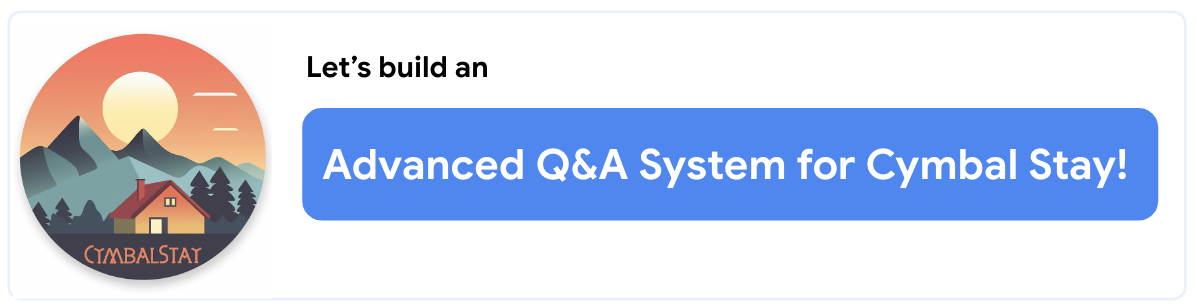

In [11]:
# Welcome Message
from IPython.display import Image
from IPython.display import display, HTML
Image("img/head.png", width=800)

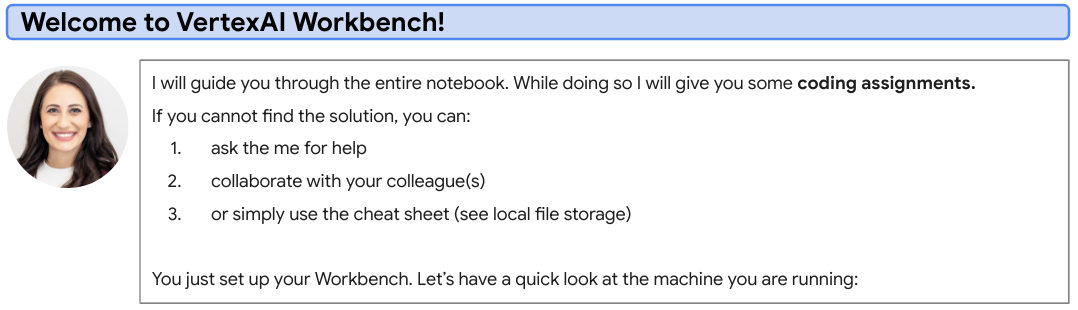

In [12]:
# Guiding Information
Image("img/task_0.png", width=800)

In [13]:
# Inspecting the Machine Type and GPU
# -----------------------------------
# Task 1: Install Watermark and retrieve system architecture by running the code below
!pip install watermark 
!pip install watermark[gpu]
%load_ext watermark
%watermark
%watermark --iversions
%watermark --gpu

Last updated: 2023-12-01T09:15:33.615522+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.10.0-26-cloud-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

requests: 2.31.0
scann   : 1.2.10
PIL     : 10.0.1
shapely : 1.8.5.post1
json    : 2.0.9
PyPDF2  : 3.0.1
numpy   : 1.23.5
IPython : 8.15.0

GPU Info: 
  GPU 0: NVIDIA L4



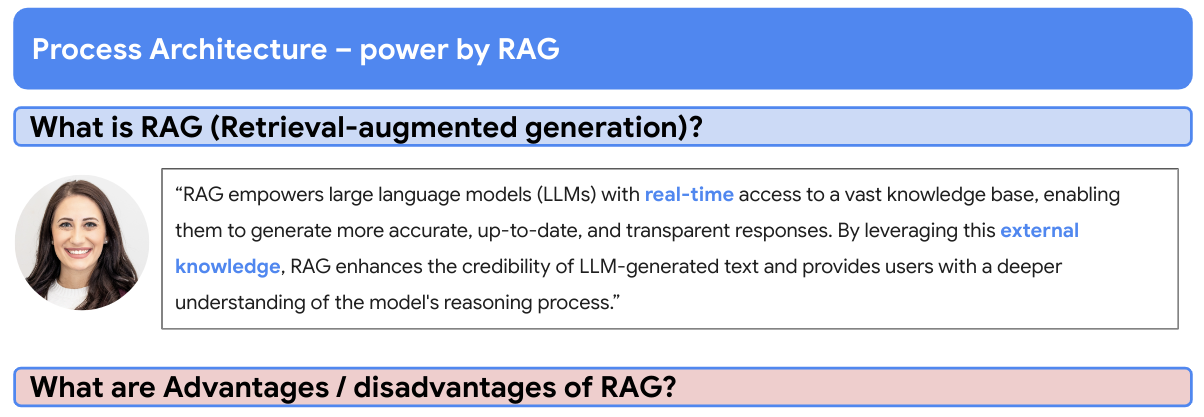

In [14]:
# Process architecture
Image("img/task_8a.png", width=800)

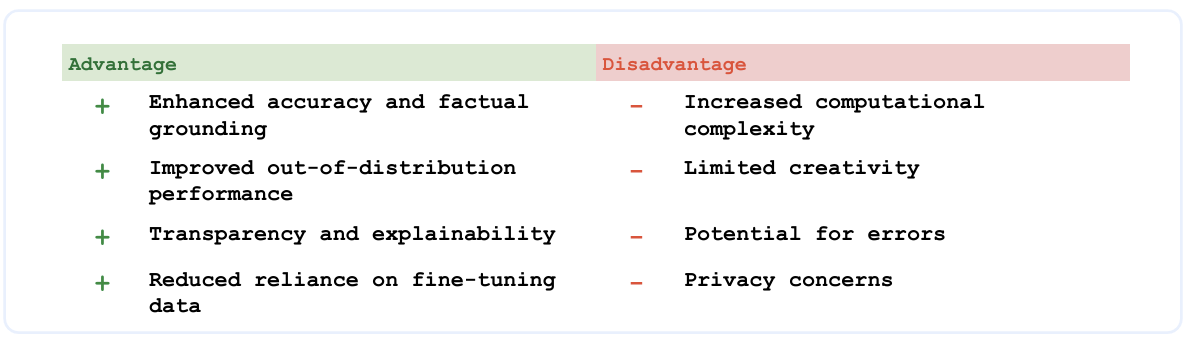

In [5]:
Image("img/task_8b.png", width=800)

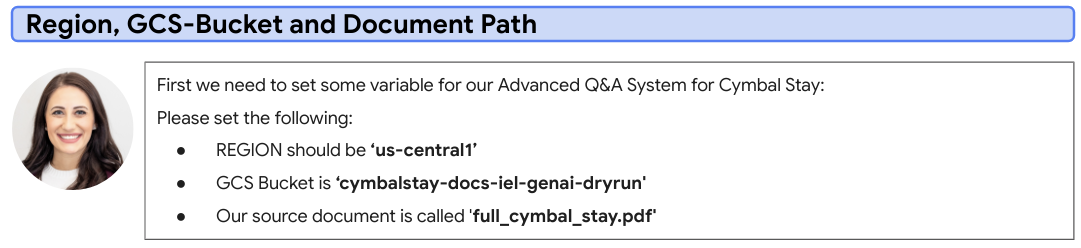

In [15]:
# Boostrapping the environment 
Image("img/task_1.png", width=800)

In [101]:
# Boostrapping the environment
# ----------------------------
# Task 2: Set the project variables
project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = 'us-central1'
GCS_BUCKET = str('cymbalstay-docs-' + PROJECT_ID)
print("Bucket name: " , GCS_BUCKET)
source_document = 'full_cymbal_stay.pdf'
PROJECT_ID


Bucket name:  cymbalstay-docs-csm-ml-demos


'csm-ml-demos'

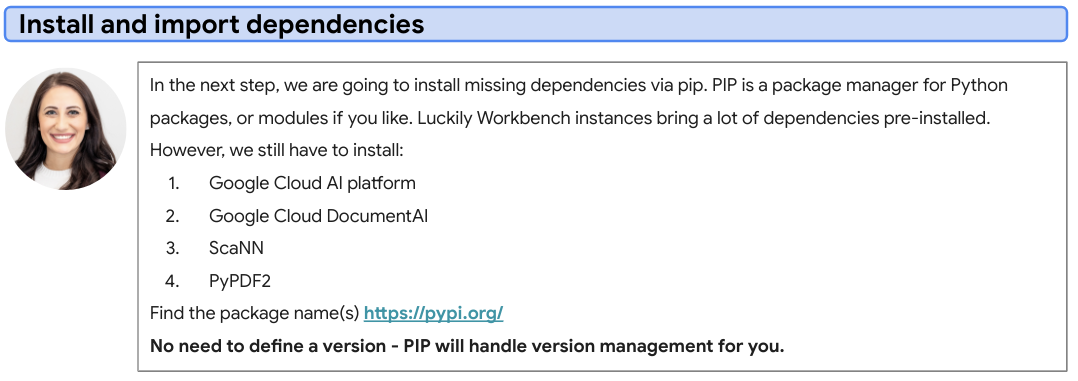

In [68]:
# Install dependencies
Image("img/task_3.png", width=800)

In [111]:
# Install dependencies
# -----------------------------------
# Task 3: Explore PyPi and install the packages accordingly using "!pip install"
display(HTML("""<b><a style="font-size: 18px" href=" https://pypi.org/">-- Visit PyPi to explore packages ---</a><b><br/><br/>"""))
# -----------------------------------
!pip install google.cloud.aiplatform
!pip install google-cloud-documentai
!pip install scann
!pip install PyPDF2
#######################################################################
# Sometimes necessary - Restart Kernel after installations:

# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [70]:
# Importing packages
# -----------------------------------
# Task 4: Import the libraries
import os
import io
import json
import base64
import requests
import concurrent.futures
import time
import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely
import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage

print("AI-Platform Version. Make sure version is above 1.30. Your Version: ", aiplatform.__version__)

AI-Platform Version. Make sure version is above 1.30. Your Version:  1.36.4


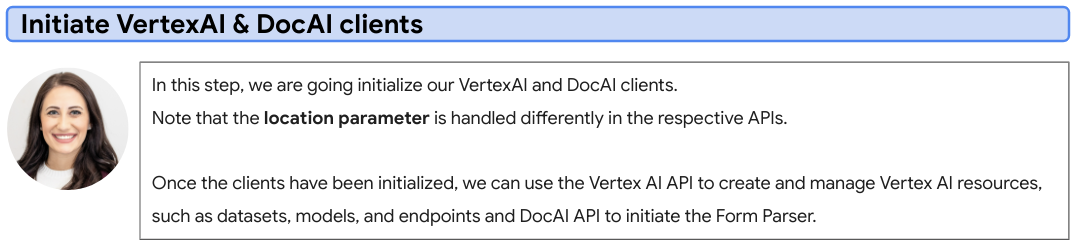

In [71]:
# Initiate VertexAI | DocAI clients 
Image("img/task_5.png", width=800)

In [72]:
# Initiate VertexAI clients 
# -----------------------------------
# Task 5a: Initialize the VertexAI and AI Platform

vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

print("Full Region name: " , REGION)

Full Region name:  us-central1


In [73]:
# Initiate Document AI client
# -----------------------------------
# Task 5b: Add your Region Prefix to the DocAI API Endpoint via client_options
# For example: us-central1-a = us | europe-west6-c = europe
REGION_PREFIX = REGION.split('-')[0]
print(REGION_PREFIX)


docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{REGION_PREFIX}-documentai.googleapis.com")
)

us


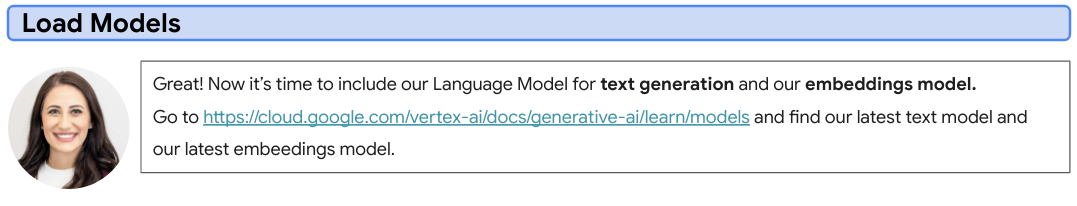

In [74]:
# Load Models
Image("img/task_6.png", width=800)

In [115]:
# Load Models
# -----------------------------------
# Task 6: Go to GCP Models and explore the latest text model and the embeedings model
display(HTML("""<b><a style="font-size: 18px" href=" https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models">-- Generative AI - Explore Models ---</a><b><br/><br/>"""))
# -----------------------------------

embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

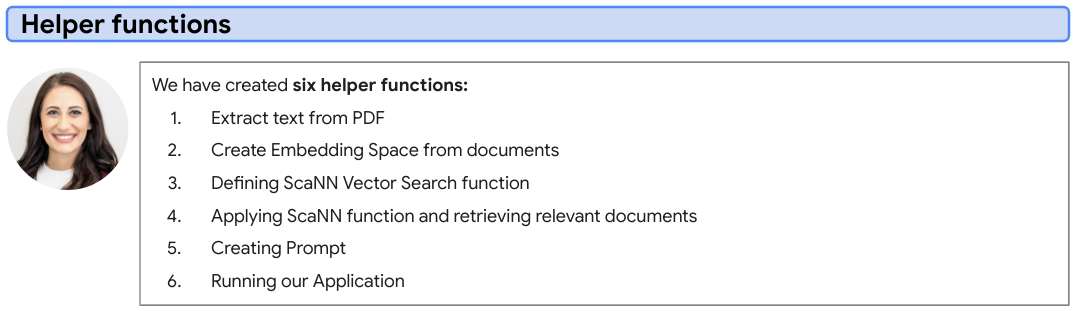

In [76]:
# Helper Functions
Image("img/task_7.png", width=800)

In [118]:
# Extract_pdf_text
# -----------------------------------
# Task 7: Go to https://cloud.google.com/document-ai/docs/form-parser
display(HTML("""<b><a style="font-size: 18px" href=" https://cloud.google.com/document-ai/docs/form-parser">-- Document AI - Explore Form Parsers ---</a><b><br/><br/>"""))
# Explore the latest form parser

In [119]:
def extract_pdf_text():
    """
    Extracts text from PDF documents using Google Cloud Document AI.

    Args:
        source_document (str): The path to the PDF document to extract text from.

    Returns:
        list: A list of dictionaries, where each dictionary represents a paragraph or table in the PDF document.
        Each dictionary contains the following keys:
            * page_content (str): The text of the paragraph or table.
            * metadata (dict): Metadata about the paragraph or table, including the page number, paragraph or table number,
            and the VME ID (a unique identifier for the paragraph or table).
            * extras (dict): Optional additional information about the paragraph or table, such as the vertices of the
            bounding box.
    """
    # Initialize Google Cloud Storage client
    gcs = storage.Client(project=PROJECT_ID)

    # Get the PDF document from the specified bucket
    bucket = gcs.bucket(GCS_BUCKET)
    blob = bucket.blob(source_document)
    response = blob.download_as_bytes()

    # Read the PDF document as a PDF object
    pdf = PyPDF2.PdfReader(io.BytesIO(response))
  
     # Extract text from each page of the PDF document
    pdfs = []
    for page_num, page in enumerate(pdf.pages, 1):
        # Create a new PDFWriter object
        writer = PyPDF2.PdfWriter()

        # Add the current page to the PDFWriter object
        writer.add_page(page)

        # Write the contents of the PDFWriter object to a BytesIO object
        with io.BytesIO() as bytes_stream:
                pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

                
     # Initialize Google Cloud Document AI client
    docfai_client = documentai.DocumentProcessorServiceClient()

    # Define parameters for Document AI processor
    PARSER_DISPLAY_NAME = "my_general_processor"
    PARSER_TYPE = "FORM_PARSER_PROCESSOR"
    

    ### Latest Parser#####################################################
    PARSER_VERSION = "pretrained-form-parser-v2.1-2023-06-26" 
    ######################################################################   
   

    # Get the Document AI processor
    parser = None
    for p in docai_client.list_processors(parent=f"projects/{PROJECT_ID}/locations/{REGION_PREFIX}"):
        if p.display_name == PARSER_DISPLAY_NAME:
            parser = p
            break               
                
    if parser is None:
        # Create a new Document AI processor if it doesn't exist
        parser = docai_client.create_processor(
            parent=f"projects/{PROJECT_ID}/locations/{REGION_PREFIX}",
            processor=dict(
                display_name=PARSER_DISPLAY_NAME, type_=PARSER_TYPE, default_processor_version=PARSER_VERSION
            ),
        )
        
    # Set the rate limit for processing PDF documents
    rate_limit_minute = 120
    adjust_rate_limit = rate_limit_minute / 2
    

    def docai_runner(p, start, raw_document):
      process_options = documentai.ProcessOptions(
      individual_page_selector=documentai.ProcessOptions.IndividualPageSelector(
          pages=[1] # e.g. in case you only want to process individual pages
      )
      )
      request = documentai.ProcessRequest(
            name=parser.name,
            raw_document=raw_document,
            process_options=process_options,
        )     
      sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
      if sleep_time > 0: time.sleep(sleep_time)
      return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))
    print(f"The expected runtime for PDF text extraction is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
    results = [None] * len(pdfs)
    start = time.time()
    with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
        futures = [
            executor.submit(
                docai_runner,
                p, start,
                documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
            ) for p, pdf in enumerate(pdfs)
        ]
        for future in concurrent.futures.as_completed(futures):
          results[future.result()[0]] = (Document.to_dict(future.result()[1].document))
    len(pdfs), len(results)
    documents = []
    page_images = []
    for r, result in enumerate(results):
        results[r]['metadata'] = dict(vme_id = str(r))
        document_image = PIL.Image.open(
            io.BytesIO(
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
                )
            )
        page_images.append(document_image)
        tables = []
        for t, table in enumerate(result['pages'][0]['tables']):
          table_txt = ''
          if 'text_anchor' in table['layout'].keys():
            for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
              if t == 0 and s == 0: start = 0
              else: start = int(segment['start_index'])
              end = int(segment['end_index'])
              table_txt += result['text'][start:end+t]
              # print(table_txt)
          documents.append(
              dict(
                  page_content = table_txt,
                  metadata = dict(
                      page = r+1,
                      table = t+1,
                      vme_id = str(len(documents)),
                      filename = source_document.split('/')[-1],
                      source_document = source_document
                  ),
                  extras = dict(
                      vertices = vertices
                  )
              )
          )
        for p, paragraph in enumerate(result['pages'][0]['paragraphs']):
          paragraph_txt = ''
          for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
            if p == 0 and s == 0: start = 0
            else: start = int(segment['start_index'])
            end = int(segment['end_index'])
            paragraph_txt += result['text'][start:end+1]
            #print(paragraph_txt)
          vertices = []
          for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
            vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
          use_paragraph = True
          for t_shape in tables:
            p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
            if p_shape.intersects(t_shape): use_paragraph = False
          if use_paragraph:
            documents.append(
                dict(
                    page_content = paragraph_txt,
                    metadata = dict(
                        page = r+1,
                        paragraph = p+1,
                        vme_id = str(len(documents)),
                        filename = source_document.split('/')[-1],
                        source_document = source_document
                    ),
                    extras = dict(
                        vertices = vertices
                    )
                )
            )
    print(f"Finished processing of {len(documents)} documents")
    return documents

def create_embedding_space(documents):
    """
    Creates an embedding space for a list of documents.

    Args:
        documents (list): A list of documents.

    Returns:
        scann.ScannTree: The embedding space.
    """

    # Set the rate limit for processing documents.
    rate_limit_minute = 150

    # Print an estimated runtime for embedding space creation.
    print(f"The expected run time for embedding space creation is {(len(documents)/rate_limit_minute):.2f} minutes")

    # Start a timer to track the processing time.
    start = time.time()

    # Process each document and extract its embedding.
    for d, document in enumerate(documents):
        if d % rate_limit_minute == 0:
            # Sleep to avoid exceeding the rate limit.
            time.sleep(((time.time() - start) % 60) + 10)
            start = time.time()

        # Get the text from the document.
        text = document['page_content']

        # Generate an embedding for the text if it exists.
        if text:
            embed = embedding_model.get_embeddings([text])[0].values
        else:
            embed = []

        # Store the embedding in the document.
        documents[d]['embedding'] = embed

    # Create an empty index to store the embeddings.
    index = np.empty((len(documents), len(documents[0]['embedding'])))

    # Check if the embeddings are lists or numpy arrays.
    if type(documents[0]['embedding']) == list:
        # Fill the index with the embeddings.
        for i in range(index.shape[0]):
            if documents[i]['page_content']:
                index[i] = documents[i]['embedding']

    # Normalize the index.
    normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

    # Create a builder for ScaNN.
    builder = scann.scann_ops_pybind.builder(
        normalized_index,  # index
        10,  # num_neighbors
        "dot_product",  # distance_measure
    )

    # Build the embedding space.
    embedding_space = builder.tree(
        num_leaves=index.shape[0],  # num_leaves
        num_leaves_to_search=index.shape[0],  # num_leaves_to_search
        training_sample_size=index.shape[0]
    ).score_ah(
        2,
        anisotropic_quantization_threshold=0.2
    ).reorder(
        index.shape[0]
    ).build()

    # Print a message indicating that the embedding space has been created.
    print("Finished creating embedding space")

    # Return the embedding space.
    return embedding_space


def search_index(embedding_space, query, k):
    """
    Search for the nearest neighbors of a query in an embedding space.

    Args:
        embedding_space: An embedding space object.
        query: A query vector.
        k: The number of nearest neighbors to return.

    Returns:
        A list of (index, distance) pairs, where `index` is the index of a neighbor in the embedding space
        and `distance` is the distance between the query and the neighbor.
    """
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = embedding_space.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))


def create_context(question, embedding_space):
    """
    Create a context for a question by finding the nearest neighbors in an embedding space and base on this retrieving the original document.

    Args:
        question: A question string.
        embedding_space: An embedding space object.

    Returns:
        A string containing the context for the question.
    """

    # Get the score for the closest match
    score = search_index(embedding_space, question, k=1)[0][1]

    # Retrieve related documents - the number is based on the distance
    # score from the closest match
    relevant_documentation = search_index(embedding_space, question, k=1 + 2 * int(10 * (1 - score)))

    # Create the context
    context = []
    for c, doc in enumerate(relevant_documentation):
        context.append(f'Context {c + 1}:\n' + documents[doc[0]]['page_content'])

    return "\n".join(context)


def create_prompt(question, context, instructions):
    """
    Create a prompt for a question by formatting the context and instructions to the original prompt.

    Args:
        question: A question string.
        context: A string containing the context for the question.
        instructions: A list of instruction strings.

    Returns:
        A string containing the formatted prompt.
    """

    return f"""
        Give a detailed answer to the question using information from the provided contexts.
        {context}
        Also include these Instructions:
        {" ".join(instructions)}

        Question:
        {question}

        Answer and Explanation:
    """


def document_bot(prompt, parameters):
    """
    Generate a response to a question and provides potential sources for the answer.

    Args:
        prompt: A prompt string.
        parameters: A dictionary of parameters to pass to the text generation model.

    Returns:
        None.
    """

    # Get the score for the closest match
    score = search_index(embedding_space, prompt, k=1)[0][1]

    # Retrieve related documents - the number is based on the distance score from the closest match
    relevant_documentation = search_index(embedding_space, prompt, k=1 + 2 * int(10 * (1 - score)))

    # Prepare context for the prompt
    context = "\n".join(
        [f'Context {c + 1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])

    # Construct the prompt
    modified_prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.
        {context}
        Also include these Instructions:
        {". ".join(instructions)}

        Question:
        {question}

        Answer and Explanation:
    """

    # Generate a response
    response = textgen_model.predict(modified_prompt, **parameters)

    # Get the closest document to the response
    likely_source = search_index(embedding_space, response.text, k=1)[0]

    # Declare the likely source: if the closest document to the response was in the context, pick it, otherwise pick the first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]

    # Format the sources
    sources = "\n".join(
        f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}"
        for doc in relevant_documentation)

    # Format the answer
    answer = f"""---
**Search results** 
Score: {score} 
Closest document: {likely_source} 
"""

    if likely:
        answer = answer + f"Document used to generate response: {likely_document['metadata']['filename']}, page: {likely_document['metadata']['page']}"
    else:
        answer = answer + f"First relevant document used to generate response: {likely_document['metadata']['filename']}, page: {likely_document['metadata']['page']}"

    answer = answer + f"""


{question}

**Answer**
{response.text}

**Potential Sources**  
{sources}
    """

    # Display the answer
    IPython.display.display(IPython.display.Markdown(answer))

# Extract text from PDF document in GCS

In [95]:
documents = extract_pdf_text()

The expected runtime for PDF text extraction is 0.48 minutes
Finished processing of 276 documents


# Create embedding space

In [96]:
embedding_space = create_embedding_space(documents)

The expected run time for embedding space creation is 1.84 minutes
Finished creating embedding space


2023-12-01 09:42:57.940416: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 276
2023-12-01 09:42:57.980822: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 40.313868ms.


# Define a Help Center question

In [81]:
question = "What is the refund policy?"

# Example Questions:
#question = "What are essential amenities for guests?"
#question = "How much is the minimum cancellation fee for Hosts on Cymbal for a confirmed reservation?"
#question = "How old is Barack Obama?"
#question = "Is it a nice time travelling to Sydney in June?"

# Create context to be used in LLM prompt

In [82]:
context = create_context(question, embedding_space)
context

'Context 1:\nGuest Refund Policy\nI\nContext 2:\nRefund conditions\nP\nContext 3:\nPlease note that your refund is subject to the Host’s cancellation policy. Additionally, your refund\namount may also be affected by:\n-\nContext 4:\nRefunds for cancellations\nY\nContext 5:\nRequest a refund\nI'

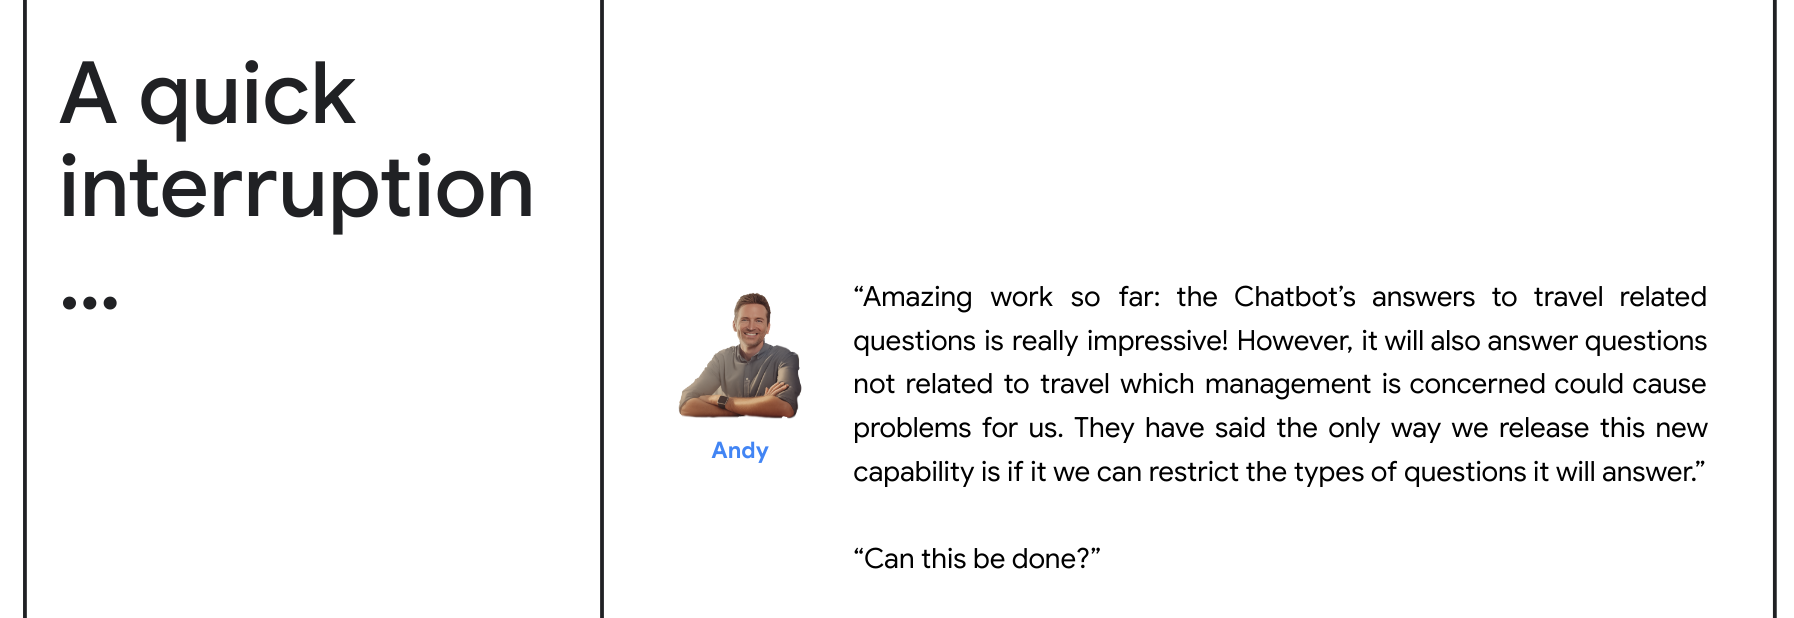

In [83]:
Image("img/quick_interruption_1.png", width=800)

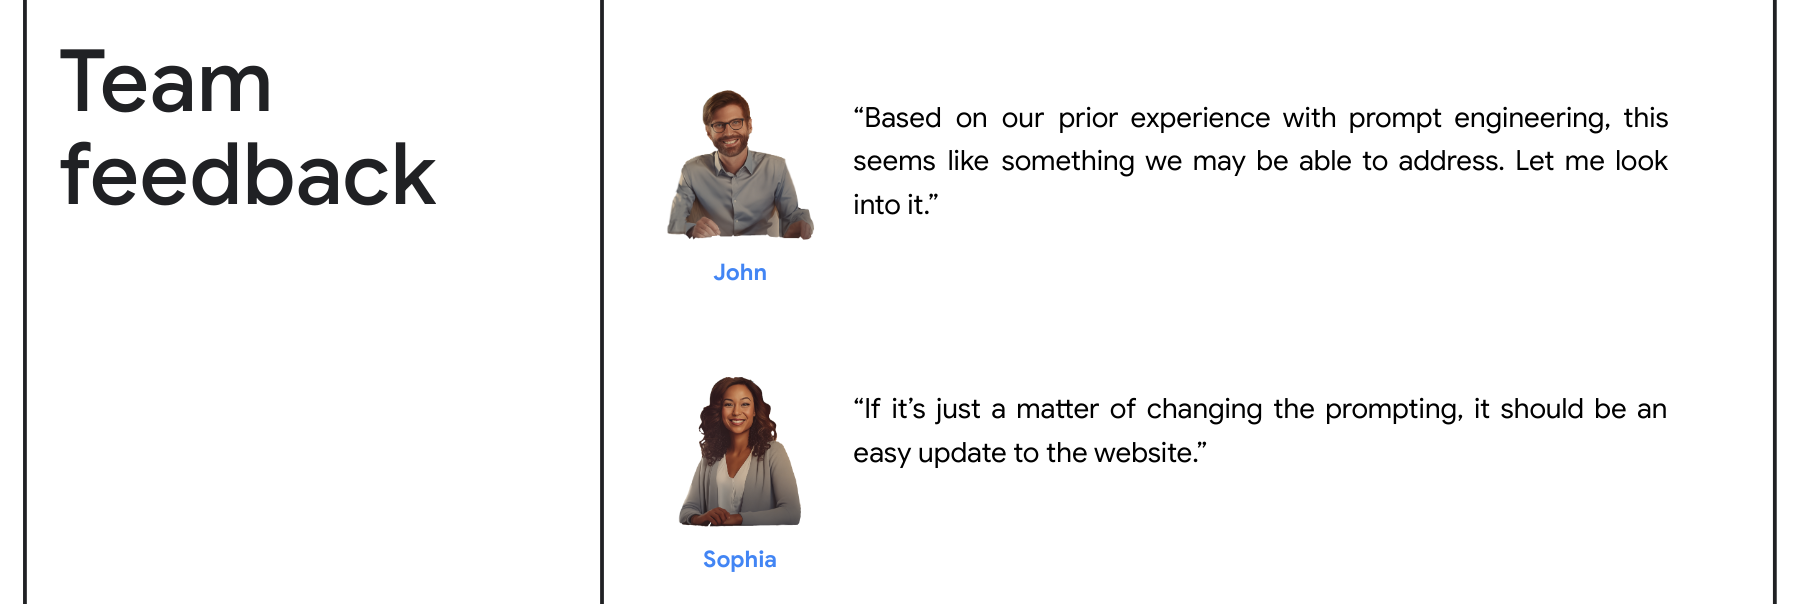

In [84]:
Image("img/quick_interruption_2.png", width=800)

# Create instructions to be used in LLM prompt

In [85]:
instructions = [
    "If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer",
    "If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model"
]
". ".join(instructions)

'If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer. If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model'

# Create LLM prompt

In [86]:
prompt = create_prompt(question, context, instructions)
prompt

'\n        Give a detailed answer to the question using information from the provided contexts.\n        Context 1:\nGuest Refund Policy\nI\nContext 2:\nRefund conditions\nP\nContext 3:\nPlease note that your refund is subject to the Host’s cancellation policy. Additionally, your refund\namount may also be affected by:\n-\nContext 4:\nRefunds for cancellations\nY\nContext 5:\nRequest a refund\nI\n        Also include these Instructions:\n        If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model\n\n        Question:\n        What is the refund policy?\n\n        Answer and Explanation:\

# Define prediction parameters

In [87]:
parameters = {
    "top_k": 40,  # A top_k of 1 means the selected token is the most probable among all tokens.
    "top_p": 0.8,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
    "temperature": 0.7,  # Temperature controls the degree of randomness in token selection.
    "max_output_tokens": 1000,  # Token limit determines the maximum amount of text output.
}

# Ask the Help Center question

In [88]:
document_bot(prompt, parameters)

---
**Search results** 
Score: 0.8127672672271729 
Closest document: (32, 0.95008796) 
First relevant document used to generate response: full_cymbal_stay.pdf, page: 3


What is the refund policy?

**Answer**
The refund policy is subject to the Host's cancellation policy. Additionally, your refund amount may also be affected by:
- Cleaning fees: Always refunded if you cancel before check-in.
- CymbalStay service fees: Service fees are refunded if you cancel during the free cancellation
period for your reservation.
- On-site property fees: If a hotel or other professional Host collects property fees on-site, any
refund of those fees is at the discretion of the Host.

**Potential Sources**  
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.81
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.81
* full_cymbal_stay.pdf#page=22
	* Document: full_cymbal_stay.pdf, page: 22, relevance to question: 0.79
    

# Ask a travel question

In [89]:
question = "Is it a nice time to travel to Sydney in June?"
context = create_context(question, embedding_space)
prompt = create_prompt(question, context, instructions)
document_bot(prompt, parameters)

---
**Search results** 
Score: 0.8519316911697388 
Closest document: (267, 0.6698215) 
Document used to generate response: full_cymbal_stay.pdf, page: 28


Is it a nice time to travel to Sydney in June?

**Answer**
The context above is not sufficient to answer the question but this is what I found in the base-model:

Yes, it is a nice time to travel to Sydney in June. The weather is mild and there are many things to see and do. Some of the top attractions in Sydney include the Sydney Opera House, the Sydney Harbour Bridge, and the Taronga Zoo. There are also many beaches and parks to visit, as well as a variety of restaurants and bars.

**Potential Sources**  
* full_cymbal_stay.pdf#page=21
	* Document: full_cymbal_stay.pdf, page: 21, relevance to question: 0.85
* full_cymbal_stay.pdf#page=28
	* Document: full_cymbal_stay.pdf, page: 28, relevance to question: 0.85
* full_cymbal_stay.pdf#page=21
	* Document: full_cymbal_stay.pdf, page: 21, relevance to question: 0.84
    

# Ask a non-travel question

In [90]:
question = "Who is Barack Obama?"
context = create_context(question, embedding_space)
prompt = create_prompt(question, context, instructions)
document_bot(prompt, parameters)

---
**Search results** 
Score: 0.7703959941864014 
Closest document: (251, 0.6084702) 
First relevant document used to generate response: full_cymbal_stay.pdf, page: 3


Who is Barack Obama?

**Answer**
the context above is not sufficient to answer the question but this is what I found in the base-model Barack Obama is an American politician who served as the 44th president of the United States from 2009 to 2017. He is the first African American to have served as president.

**Potential Sources**  
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.77
* full_cymbal_stay.pdf#page=11
	* Document: full_cymbal_stay.pdf, page: 11, relevance to question: 0.77
* full_cymbal_stay.pdf#page=11
	* Document: full_cymbal_stay.pdf, page: 11, relevance to question: 0.76
* full_cymbal_stay.pdf#page=27
	* Document: full_cymbal_stay.pdf, page: 27, relevance to question: 0.76
* full_cymbal_stay.pdf#page=22
	* Document: full_cymbal_stay.pdf, page: 22, relevance to question: 0.76
    

# Change instructions to restrict to travel questions

In [91]:
instructions = [
    "If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer",
    "If the prompt does not contain a travel specific question then do not contiune. Instead end the conversation with: This is not a travel question, sorry I cannot answer this",
    "If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model"
]
". ".join(instructions)

'If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer. If the prompt does not contain a travel specific question then do not contiune. Instead end the conversation with: This is not a travel question, sorry I cannot answer this. If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model'

# Ask the non-travel related question again

In [92]:
question = "Who is Barack Obama?"
context = create_context(question, embedding_space)
prompt = create_prompt(question, context, instructions)
document_bot(prompt, parameters)

---
**Search results** 
Score: 0.7874475717544556 
Closest document: (46, 0.6451299) 
First relevant document used to generate response: full_cymbal_stay.pdf, page: 3


Who is Barack Obama?

**Answer**
This is not a travel question, sorry I cannot answer this.

**Potential Sources**  
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.79
* full_cymbal_stay.pdf#page=27
	* Document: full_cymbal_stay.pdf, page: 27, relevance to question: 0.78
* full_cymbal_stay.pdf#page=22
	* Document: full_cymbal_stay.pdf, page: 22, relevance to question: 0.78
* full_cymbal_stay.pdf#page=11
	* Document: full_cymbal_stay.pdf, page: 11, relevance to question: 0.77
* full_cymbal_stay.pdf#page=11
	* Document: full_cymbal_stay.pdf, page: 11, relevance to question: 0.77
    